
# Web Mining - Project : #

***

## Objectif : 

<p>
Mining social media network (FaceBook, Twitter, etc.) and news websites </br>
for discovering what topics Moroccan people are discussing during the two last years.  

- Use LDA (Latent Dirichlet Allocation) or other topic identification techniques.

- Provide a deep analysis.
</p>

***
</br>

### Importation des libraires :


In [8]:
!pip install -U -r requirements.txt

Requirement already up-to-date: nltk in c:\python\python37\lib\site-packages (from -r requirements.txt (line 4)) (3.4.5)
Requirement already up-to-date: gensim in c:\python\python37\lib\site-packages (from -r requirements.txt (line 5)) (3.8.1)
Requirement already up-to-date: tweepy in c:\python\python37\lib\site-packages (from -r requirements.txt (line 6)) (3.8.0)
Requirement already up-to-date: googletrans in c:\python\python37\lib\site-packages (from -r requirements.txt (line 7)) (2.4.0)
Requirement already up-to-date: langdetect in c:\python\python37\lib\site-packages (from -r requirements.txt (line 8)) (1.0.7)
Requirement already up-to-date: textblob in c:\python\python37\lib\site-packages (from -r requirements.txt (line 9)) (0.15.3)
Requirement already up-to-date: autocorrect in c:\python\python37\lib\site-packages (from -r requirements.txt (line 10)) (0.4.4)
Requirement already up-to-date: alphabet-detector in c:\python\python37\lib\site-packages (from -r requirements.txt (line 1

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Accès refusé: 'c:\\python\\python37\\lib\\site-packages\\~-mpy\\core\\_multiarray_tests.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [1]:
import numpy as np
import pandas as pd 
import re
from tqdm.notebook import tqdm

from googletrans import Translator
from langdetect import detect
from textblob import TextBlob

import gensim
from gensim import corpora, models, similarities
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords

home = 'D:/WISD/S3/Web_Mining/Current_Trends_in_Moroccan_Social_Networks/'

from jupyterthemes import jtplot
jtplot.style()

# Processing tweets with NLP #

***

#### *The steps we followed to process the stored Tweets are:*

- *a)* Delete unnecessary data: usernames,emails,hyperlinks, retweets, punctuation, 
possessives from a noun,duplicate characters, and special characters like smileys.

- *b)* Normalize whitespace (convert multiple sequential whitespace chars into one whitespace character).

- *c)* Convert hashtags into separate words, for example, thehashtag #MoroccanUsers 
is converted into two wordsMoroccan and Users.

- *d)* Transform words writtenin Moroccan dialect, or in a dialect of Berber Tamazight into Standard Arabic. 
These words couldbe written using the Arabic or French alphabet. 
To performthistask, we create a python file that contains a dictionary of words that we gathered, 
then we store it in each slave node of our clusterand imported inside the NLP script

- *e)* Create a function to detect the language used to write
the text of tweet (Standard Arab, French or English).

- *f)* Create a function for automatic correction of spelling mistakes.

- *g)* Create a list of contractions to normalize and
expandwordslike What's=>What is

- *h)* Delete the suffix of a word until we find the root. For
example; Stemming => stem

- *i)* Remove stopwords for standard Arabic ( ,(...,أن, إن, بعد
French (alors, à, ainsi, ...), and English (about, above, almost,...).


## a) Delete unnecessary data: usernames, emails, hyperlinks, punctuation, duplicate characters, and special characters like smileys (emoji). ##

In [9]:
# first to detect the types of emoji and to eliminate them we use the demoji library from https://pypi.org/project/demoji/
import demoji
demoji.download_codes()

... OK (Got response in 1.01 seconds)
Writing emoji data to C:\Users\mhmh2\.demoji/codes.json ...
... OK


In [2]:
''' secondly after the library install and the download of the data i found that  the type of this file is .json
so i try to read it using pandas and it give a good result because of that i just use it's datasit (.json)
'''
df = pd.read_json('C:/Users/mhmh2/.demoji/codes.json')
df

,timestamp,codes
#⃣,2020-01-06 17:45:43.688815117,keycap: #
#️⃣,2020-01-06 17:45:43.688815117,keycap: #
*⃣,2020-01-06 17:45:43.688815117,keycap: *
*️⃣,2020-01-06 17:45:43.688815117,keycap: *
0⃣,2020-01-06 17:45:43.688815117,keycap: 0
...,...,...
🪑,2020-01-06 17:45:43.688815117,chair
🪒,2020-01-06 17:45:43.688815117,razor
🪓,2020-01-06 17:45:43.688815117,axe
🪔,2020-01-06 17:45:43.688815117,diya lamp


In [10]:
demoji_df = pd.read_json(home + 'demoji.json', encoding='utf-8') # from https://pypi.org/project/demoji/
demoji_df.reset_index(inplace=True)
demoji_df.astype({"index": str})

def delete_unnecessary_data(tweet):
    #delete www.* or https?://* 
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    #delete @username
    tweet = re.sub(' @[^\s]+',' ',tweet)
    #delete username*
    tweet = re.sub('username[^\s]+','',tweet)
    #delete emails
    tweet = re.sub('[^\s@]+@[^\s@]+',' ',tweet)

    #delete javascript tags
    tweet =re.sub('< *script*>.*?< *script*>',' ',tweet)
    #delete all html tags
    tweet = re.sub('<.*?>',' ',tweet)
    #delete numbers 
    tweet = re.sub("[0-9><,]+"," ",tweet)
    #delete reteur a la ligne
    tweet = re.sub(r"\n+|┊"," ",tweet)

    # delete duplicate characters
    tweet = re.sub(r"(.)\1{2,}", r"\1\1", tweet)
    
    # Remove special characters like smileys (imojie)
    '''
    😂🤷‍♀️❤️🔴📢✅❎🥘↘️🌻♥️♥️♥️🥵🆚📅🕗📍👋😩😢🙌🏾🔥😮💖😭👄❤🤢💥💣
    🎄❤❤🐪🐱💰🏷⭐🙄😍🙌👇💚😭😹🌸💛🙏👏😔🎁🥰❄🎄💤
    '''     
    # tweet = re.sub(r'😂|🤷‍♀️|❤️|🔴|📢|✅|❎|🥘|↘️|🌻|♥️️|️🥵|🆚|📅|🕗|📍|👋|😩|😢|🙌🏾|🔥|😮|💖|😭|👄|❤|🤢|💥|💣','',tweet)
    # Stage el wa7che
    # tweet = tweet.encode('ascii', 'ignore').decode('ascii')
    
    for code in demoji_df["index"]:
        try:
            tweet = re.sub(code, '', tweet)
        except:
            pass
        
    return tweet

*test* :

In [11]:
text = "┊✨ ┊ 💧رقي ┊🍃🌟💧ابداااع┊🌟┊✨┊🌟┊💧ذوووق┊🍃┊🌟┊💧فخامة┊✨🌟┊💧اناقه."
# text =' ┊ test'
# text = ' tdg@bkja "قول بذلت جهدي والباقي على الله؟ 😹😹😹😹 https://t.co/YalhezFnsl "#acsjjfac !\n @ # % ^ & * ( 📢✅❎🥘↘️🌻♥️♥️♥️🥵🆚📅🕗📍👋😩😢🙌🏾🔥😮💖😭👄❤🤢💥💣'
text = delete_unnecessary_data(text)
text

'   رقي  ابدااع    ذووق   فخامة  اناقه.'

## b) Normalize whitespace (convert multiple sequential whitespace chars into one whitespace character). ##

In [12]:
def normalize_whitespace(tweet):
    tweet = re.sub('[\s]+', ' ', tweet)
    return tweet

*test* :

In [13]:
text = normalize_whitespace(text)
text

' رقي ابدااع ذووق فخامة اناقه.'

## c) Convert hashtags into separate words, for example, thehashtag #MoroccanUsers is converted into two words Moroccan and Users. ##

In [14]:
def sp_h(hashtagestring):
    fo = re.compile(r'#[A-Z]{2,}(?![a-z])|[A-Z][a-z]+')
    fi = fo.findall(hashtagestring)
    return ' '.join(fi)

def split_hashtage(tweet):
    tweet = re.sub(r'#[^\s]+', lambda m: sp_h(m.group()), tweet) # #WakeUpMorocco => Wake Up Morocco
    return tweet

In [15]:
# import unicodedata as ud
# import string

def reamove_punctuation(tweet):
#     regex = re.compile('[%s]' % re.escape(string.punctuation))
#     tweet = regex.sub('', tweet)
#     tweet = re.sub(ud.category(c).startswith('P'),'',tweet)

    tweet = re.sub('[^\w\s\']',' ',tweet)
#     tweet = ''.join(c for c in tweet if not ud.category(c).startswith('P'))
    return tweet

## e) Create a function to detect the language used to write the text of tweet (Standard Arab, French or English). ##

If their is an onther language  we convert it to English 

In [16]:
from googletrans import Translator
translator = Translator()
from langdetect import detect
from textblob import TextBlob

def language_detction(tweet):
    try:
        lang = translator.detect(tweet).lang
    except:
        try:
            lang = detect(tweet)
        except:
            try:
                lang = str(TextBlob(tweet).detect_language())
            except:
                lang = 'unknown'
    
    if lang in ['ar', 'arfa', 'fa', 'faar'] :
        tweet = correct_ar(tweet)
    elif lang == 'fr':
        tweet = correct_fr(tweet)
    elif lang == 'en':
        tweet = correct_en(tweet)
    else:
        tweet = translator.translate(tweet,src='auto',dest='en' ).text
        tweet = correct_en(tweet)
    return tweet

*test* :

In [17]:
text = 'chkon nta'
# text = "اتبارك الله على الحاج راك تما.هه"
# text = 'hhh je suis encore vivant'
# text ='كيف يمكن تعزيز كفاءات هذا الجهاز بتطويره بآستخذام الذكاء الإصطناعي ؟ مثلا يمكن إستعمال قلم يغير قطر الكتابة أو تغيير لون الحبر بدون تغيير القلم فقط بإصدار الأوامر، ماذا عنكم ؟'
dt = translator.detect(text)
a = translator.translate(text,src='auto',dest='en' ).text
print(text , "\t\t", a , "\t\t", dt)

chkon nta 		 who are you 		 Detected(lang=ar, confidence=1.0)


## f) Create a function for automatic correction of spelling mistakes. ##


### The correction of spelling mistakes of English ###

In [18]:
from autocorrect import Speller
spell = Speller(lang='en')

def correct_en(text):
    #convert to lower case
    text = text.lower()
    # Clean the text
    text = re.sub("\'s ", " is", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(r" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("n\'t", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE) #mester(s)
    text = re.sub(r" (the[\s]+|The[\s]+)?(us(a)?|u\.s\.(a\.)?|united state(s)?) ", " america ", text)
    text = re.sub(r" uk ", " england ", text, flags=re.IGNORECASE)
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r"bn8|god8" ,'good night', text, flags=re.IGNORECASE)
    text = re.sub(r" 2moro | 2mrrw | 2morrow | 2mrw | tomrw ", " tomorrow ", text)
    text = re.sub(r" b4 ", " before ", text)
    text = re.sub(r" otw ", " on the way ", text)

    text = spell(text)

    return text

### The correction of spelling mistakes of French ###

In [19]:
from textblob import TextBlob

def correct_fr(text):
    text = TextBlob(text).correct()
    return str(text)

*test* :

In [20]:
print(correct_fr('je mangee le banane et la pom'))

je manger le banana et la pot


### The correction of spelling mistakes of Arabic  ###

#### d) Transforming words written in Moroccan dialect 
(by the French alphabet or Arabic) and also written in a dialect of Berber Tamazight (by the French alphabet into the standard Arabic. 

For this reason, we create a dictionary of words that we gathered in a python file to perform this task, This file will be stored in each slave node of our cluster, and it will be imported in the NLP script executed in these nodes, the file looks like

In [21]:
word_ma_df = pd.read_csv( home + "Moroccan_dialect.csv", sep=';',encoding='utf-8')
word_ma_df

,English,Arabic,Transcribed Moroccan Arabic,Moroccan Darija in the Arabic Alphabet
0,Yes,نعم,Iyyeh,إييه
1,Yes,نعم,ah,آه
2,Yes,نعم,wah,واه
3,No,لا,Lla,لا
4,Please,من فضلك,3afak,عافاك
...,...,...,...,...
126,Sociology,علم الإجتماع,3ilm el2ijtima3,علم الإجتماع
127,Space science,علم الفضاء,3ilm elfada2,علم الفضاء
128,Statistics,الإحصاء,El2i7sa2,الإحصاء
129,Veterinary medicine,الطب البيطري,Ettebb elbaytari,الطب البيطري


In [22]:
def moroccan_dialect(tweet):
    tweet= ' '+tweet+' '
    for ligne in word_ma_df.values:
        tweet = re.sub(r' '+str(ligne[2])+' | '+str(ligne[3])+' ', ' '+str(ligne[1])+' ', tweet)
    return tweet

*test* :

In [23]:
tweet = 'ahramon Ettebb elbaytari 3afak إييه wah 3tini'
tweet = moroccan_dialect(tweet)
tweet

' ahramon الطب البيطري من فضلك نعم نعم أعطني '

 We impliment scrapy in the file : mylanguagesSpider.py
 
 to scrape the website : 'http://mylanguages.org/moroccan_vocabulary.php'  
 
 This latter including a course about vocabulary and expressions to learn Moroccan Vocabulary

In [24]:
word_ma_df2 = pd.read_csv( home + "mylanguages.csv", sep=',',encoding='utf-8')
word_ma_df2

,en,ar,mafr
0,numbers,أرقام,nmari
1,one,واحد,wahade
2,two,اثنان,zouje
3,three,ثلاثة,tlata
4,four,أربعة,rabaa
...,...,...,...
673,professor,أستاذ,oustade
674,teacher,معلم,mouaalime
675,teacher,معلم,mou3alime
676,uncle,عم,ame


In [25]:
def moroccan_dialect2(tweet):
    tweet= ' '+tweet+' '
    for ligne in word_ma_df.values:
        tweet = re.sub(r' '+str(ligne[2])+' ', ' '+str(ligne[1])+' ', tweet)
    return tweet

In [26]:
# from https://alraqmiyyat.github.io/2013/01-02.html
def normalizeArabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    return(text)

normalizeArabic(tweet)

' ahramon الطب البيطري من فضلك نعم نعم اعطني '

in this fonction we try to eliminate the Arabic Diacritics

In [ ]:
# from https://alraqmiyyat.github.io/2013/01-02.html
def deNoise(text):
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    return text

test :

In [67]:
testLine = "إِنَّ الْقُرَّاْءَ يَقْرَؤُوْنَ الْقُرْآنَ قِرَاْءَةً جَمِيْلَــــــةً"
print(deNoise(testLine))

إن القراء يقرؤون القرآن قراءة جميلة


In [30]:

import pyarabic.araby as araby

ModuleNotFoundError: No module named 'pyarabic'

In [28]:
def correct_ar(text):
    text = moroccan_dialect(text)
    text = moroccan_dialect2(text)
    text = normalizeArabic(text)
    text = deNoise(text)
    
    return text

## import the stopwords ##

In [29]:
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords

stop_words = stopwords.words('arabic')
with open("arabic_stop_words.txt","r", newline="",encoding="utf-8") as f:        
    for l in f:
        l = re.sub(r"\n+",'',l)
        stop_words.append(l)

stop_words.extend(stopwords.words('french'))
stop_words.extend(stopwords.words('english'))
stop_words.extend(gensim.parsing.preprocessing.STOPWORDS)
stop_words.extend(['tout','le','la'])
stop_words = set(stop_words)


## lemmatize stemming tokenization ##

In [30]:
import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer

stemmer = PorterStemmer()
lmtzr = WordNetLemmatizer()

def lemmatize_stemming(text):
    return stemmer.stem(lmtzr.lemmatize(text, pos='v'))


def tokenize_lemmatize_stemming(text):
    text = re.sub(r'[^\w\s]','',text)
    #replace multiple spaces with one space
    text = re.sub(r'[\s]+',' ',text)
    #transfer text to lowercase
    text = text.lower() 
    # tokenaze text
    tokens = re.split(" ", text)

    # Remove stop words 
    result = []
    for token in tokens :
        if token not in stop_words and len(token) > 1:
            result.append(lemmatize_stemming(token))

    return result

## Globale Fonction

In [31]:
def preprocess(tweet):
    tweet = delete_unnecessary_data(tweet)
    tweet = normalize_whitespace(tweet)
    tweet = split_hashtage(tweet)
    tweet = reamove_punctuation(tweet)
    tweet = language_detction(tweet)
#     return tweet
    tokens = tokenize_lemmatize_stemming(tweet)
    return tokens

*test* :

In [32]:
# text = "┊✨ ┊ 💧رقي ┊🍃🌟💧ابداااع┊🌟┊✨┊🌟┊💧ذوووق┊🍃┊🌟┊💧فخامة┊✨🌟┊💧اناقه."
# text = '   رقي  ابدااع    ذووق   فخامة  اناقه.'
text =' RT @PsiliLemonia: Πώς να βάλεις φωτιά στο κρεβάτι σας με εφτά απλές κινή'
# text = "Se realmente quisessem estar do meu lado iam estar, e quem tá já basta viu!"
# text = preprocess("قول بذلت جهدي والباقي على الله؟ 😹😹😹😹 https://t.co/YalhezFnsl ")
text = preprocess(text)
# print(delete_unnecessary_data("قول بذلت جهدي والباقي على الله؟ 😹😹😹😹 https://t.co/YalhezFnsl "))
print(text)

# dt = translator.detect(text).lang

# tweet = translator.translate(text,src='auto',dest='en' ).text
# print(text , "\n",dt)

['rt', 'bed', 'seven', 'simpl', 'movement']


# Load The Data #

***

## twitter Data set scaraping with twepy

In [28]:
columns = ['user','date','text']
tweets_df  = pd.read_csv(home+'tweets.csv',encoding='utf-8')
tweets_df.columns = columns
tweets_df2 = pd.read_csv(home+'tweets.csv',encoding='utf-8')
tweets_df2.columns = columns
tweets_df3 = pd.read_csv(home+'tweets3.csv',encoding='utf-8')
tweets_df3.columns = columns
tweets_df = pd.concat([tweets_df3, tweets_df2, tweets_df])
# tweets_df = tweets_df3
# tweets_df.columns = columns
tweets_df.astype({'text': str, 'date': str, 'text': str, 'user': str})
tweets_df = tweets_df.drop_duplicates()
tweets_df.reset_index(drop = True, inplace=True)
tweets_df

,user,date,text
0,Neryum1,2019-12-30 12:43:24,RT @JuiKoruBin: Dio quand il a vue jotaro ...
1,Aderonk003,2019-12-30 12:43:24,@Airreys_perri 🙈🙈🙈🙈🙈🙈
2,CristianCant7,2019-12-30 12:43:23,El mejor momento del día es desayunar con mi v...
3,moutune2,2019-12-30 12:43:23,Sobolo and meat pie cravings
4,BeLikeSpirit,2019-12-30 12:43:22,RT @ass_w2: Fav et jte fait un direct jmennuie...
...,...,...,...
282114,mariamarrerodd,2019-12-28 01:52:26,"RT @osiieu: Me lo repito cada vez que salgo, y..."
282115,jose_reyeslopez,2019-12-28 01:50:37,La incompetecia de un Presidente cobarde da pa...
282116,lidebsss,2019-12-28 01:50:02,I was real close with one of the prettiest gir...
282117,QueenZNB,2019-12-28 01:37:13,وش صاير يا ناس!!! ترويج بامريكا؟ https://t.co/...


In [29]:
tweet = tweets_df['text'][0]
preprocess(tweet)

['rio', 'quand', 'vue', 'potato', 'dio', 'quand', 'potato', 'arrêtez', 'temp']

## Hespress dataset scraping withe Scrapy 

In [30]:
hespress_df  = pd.read_csv(home+'HespressComments.csv',encoding='utf-8') # 2019
# hespress_df.astype({'text': str, 'date': str, 'text': str, 'user': str})
hespress_df = hespress_df.drop_duplicates()
hespress_df.reset_index(drop = True, inplace = True)
hespress_df

,titel,type,topic_url,date,comment
0,حماس كبير يجمع متسابقي رالي داكار بالسعودية,sport,https://www.hespress.com/sport/455321.html,2020/01/04,واش داكار ولات فالسعودية ? فهمونا
1,حماس كبير يجمع متسابقي رالي داكار بالسعودية,sport,https://www.hespress.com/sport/455321.html,2020/01/04,نفس السباق وبنفس الاسم كان يقام في امريكا الجن...
2,حماس كبير يجمع متسابقي رالي داكار بالسعودية,sport,https://www.hespress.com/sport/455321.html,2020/01/04,المعلق 1 - البئساء
3,حماس كبير يجمع متسابقي رالي داكار بالسعودية,sport,https://www.hespress.com/sport/455321.html,2020/01/04,صاحب تعليق البؤساء رقم 1 : انه مجرد تغيير للبو...
4,حملة دعم مرضى السرطان .. صحافيون يصرخون في وجه...,societe,https://www.hespress.com/societe/455310.html,2020/01/04,مبادره طيبه جدا حظ موفق. اللهم رب الناس اذهب ا...
...,...,...,...,...,...
553673,دراسة ترصد عواقب مدمرة للفطور غير الصحي,sciences-nature,https://www.hespress.com/sciences-nature/41746...,2019/01/02,الحمدالله اتاي زيت زيتون مع خبر قمح عيشن بحل س...
553674,دراسة ترصد عواقب مدمرة للفطور غير الصحي,sciences-nature,https://www.hespress.com/sciences-nature/41746...,2019/01/02,الفطور بالبيض يوميا مضر و خطر على الصحة لا يجو...
553675,دراسة ترصد عواقب مدمرة للفطور غير الصحي,sciences-nature,https://www.hespress.com/sciences-nature/41746...,2019/01/02,البيض البلدي صحي ومفيد ولايرفع الكلسترول حتى و...
553676,نزهة بيدوان تلتقي نزلاء السجن المحلي آيت ملول,regions,https://www.hespress.com/regions/417444.html,2019/01/02,اتساءل كم من ميدالية ذهبية حصلت عليها هده العد...


In [43]:
text = hespress_df['comment'][0]
preprocess(text)

['واش', 'داكار', 'ولات', 'فالسعودية', 'فهمونا']

## Facebook Data scraped with 


In [44]:
facebook_df  = pd.read_csv(home+'facebookPosts.csv',encoding='utf-8')
facebook_df

,text,date,link
0,مباشرة من بلجيكا: جولة صغيرة بمدينة فيرفيي .. ...,2020/01/06,NaN
1,زيان: لجنة النموذج التنموي لشكيب بنموسى تساهم ...,2020/01/06,https://m.facebook.com/story.php?story_fbid=32...
2,مباشرة من مليلية : مغادي تفهمو والو شوفو غرائب...,2020/01/06,NaN
3,مباشرة من طنجة: شوفو الأجواء بالمدينة مساء الإ...,2020/01/06,NaN
4,الشرطة القضائية بطانطان تتمكن من حجز طُنين و98...,2020/01/06,https://m.facebook.com/story.php?story_fbid=32...
...,...,...,...
28659,La 8 éme édition du Festival de Fès du théatre...,2013/05/03,NaN
28660,L’Ecole Nationale de Commerce et Gestion de Fè...,2013/04/27,NaN
28661,La deuxième édition de startup-weekend Fès a e...,2013/04/26,NaN
28662,The great debater 09-03-2013\nhttp://www.usmba...,2013/03/09,https://m.facebook.com/story.php?story_fbid=56...


In [32]:
df = pd.concat([tweets_df['text'],  hespress_df['comment'],  hespress_df['titel']])
df

0         RT @JuiKoruBin: Dio quand il a vue jotaro     ...
1                                     @Airreys_perri 🙈🙈🙈🙈🙈🙈
2         El mejor momento del día es desayunar con mi v...
3                              Sobolo and meat pie cravings
4         RT @ass_w2: Fav et jte fait un direct jmennuie...
                                ...                        
553673              دراسة ترصد عواقب مدمرة للفطور غير الصحي
553674              دراسة ترصد عواقب مدمرة للفطور غير الصحي
553675              دراسة ترصد عواقب مدمرة للفطور غير الصحي
553676        نزهة بيدوان تلتقي نزلاء السجن المحلي آيت ملول
553677        نزهة بيدوان تلتقي نزلاء السجن المحلي آيت ملول
Length: 1389475, dtype: object

In [ ]:
# Create and register a new `tqdm` instance with `pandas`
tqdm.pandas()

# Now you can use `progress_apply` instead of `apply`
# df.apply(lambda x: preprocess(x))
df.progress_apply(lambda x: preprocess(x))

In [ ]:
# tokens = []
# for tweet in tqdm(tweets_df['text']):
#     tokens.append(preprocess(tweet))
        

In [44]:
with open(home+'clean_data.txt', 'r', encoding='utf-8') as f:
    data = f.readlines()

tokens = []
for text in data:
    text = re.sub(r"\n",'', text)
    tokens.append(text.split(','))

# How to create Topic Models with LDA? #

***

<p>
The objective of topic models is to extract the underlying topics from a given collection of text documents. Each document in the text is considered as a combination of topics and each topic is considered as a combination of related words.
</p>

<p>
Topic modeling can be done by algorithms like Latent Dirichlet Allocation (LDA) and Latent Semantic Indexing (LSI).
</p>

<p>
In both cases you need to provide the number of topics as input. The topic model, in turn, will provide the topic keywords for each topic and the percentage contribution of topics in each document.
</p>

<p>
The quality of topics is highly dependent on the quality of text processing and the number of topics you provide to the algorithm. The earlier post on how to build best topic models explains the procedure in more detail. However, I recommend understanding the basic steps involved and the interpretation in the example below.
</p>
</br>

*Idea* from : 
* https://www.machinelearningplus.com/nlp/gensim-tutorial/
* https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
* https://github.com/susanli2016/NLP-with-Python/blob/master/LDA_news_headlines.ipynb

In [45]:
dictionary = corpora.Dictionary(tokens)
print(dictionary)
print(dictionary.num_docs)

Dictionary(64145 unique tokens: ['ayoub', 'free', 'الدرس', 'السجن', 'ايوب']...)
29369


In [46]:
# Show the word to id map
print(dictionary.token2id)

{'ayoub': 0, 'free': 1, 'الدرس': 2, 'السجن': 3, 'ايوب': 4, 'حجرة': 5, 'مكان': 6, 'بالتوفيق': 7, 'للجميع': 8, 'الاعلان': 9, 'الامتحانات': 10, 'الطلبة': 11, 'الكلية': 12, 'حظ': 13, 'داخل': 14, 'لاجتياز': 15, 'لواءح': 16, 'موفق': 17, 'موقع': 18, 'وعبر': 19, 'الطالبات': 20, 'بداية': 21, 'لكل': 22, 'موفقة': 23, 'fe': 24, 'fsdm': 25, 'news': 26, 'الجديد': 27, 'العام': 28, 'بالفالدسيون': 29, 'معا': 30, 'نقفز': 31, 'اجتياز': 32, 'الاستدراكية': 33, 'الجدد': 34, 'الدورة': 35, 'الصفر': 36, 'بالنسبة': 37, 'تخول': 38, 'تذكير': 39, 'للطلبة': 40, 'نقطة': 41, 'الفتوح': 42, 'باب': 43, 'الخريفية': 44, 'الزمن': 45, 'امتحانات': 46, 'باق': 47, 'الاداب': 48, 'الجامعي': 49, 'الحقوق': 50, 'العلوم': 51, 'بالمركب': 52, 'بطاقة': 53, 'توزع': 54, 'كلية': 55, 'منحتي': 56, 'هام': 57, 'الجدولة': 58, 'الخاصة': 59, 'الشعب': 60, 'بامتحانات': 61, 'البريد': 62, 'البنك': 63, 'التاريخ': 64, 'المحدد': 65, 'الممنوحين': 66, 'بهو': 67, 'بوكالة': 68, 'لسحب': 69, 'لقد': 70, 'وكذا': 71, 'الصفحة': 72, 'الطاقم': 73, 'الله': 74, 'الم

We have successfully created a Dictionary object. Gensim will use this dictionary to create a bag-of-words corpus where the words in the documents are replaced with its respective id provided by this dictionary.

## Term Frequency

In [47]:
# la methode : doc2bow(document,...)  kt7awel les word --> l' vector d les frequense des mots
corpus_doc2bow_vectors = [dictionary.doc2bow(tok_doc) for tok_doc in tokens]
print("# Term Frequency : ")
corpus_doc2bow_vectors[:5]

# Term Frequency : 


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)],
 [(7, 1), (8, 1)],
 [(8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 2),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1)],
 [(11, 1), (20, 1), (21, 1), (22, 1), (23, 1)],
 [(24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)]]

## TF-IDF

In [48]:
tfidf_model = models.TfidfModel(corpus_doc2bow_vectors, id2word=dictionary, normalize=False)
corpus_tfidf_vectors = tfidf_model[corpus_doc2bow_vectors]
print("\n\n# TF_IDF : ")
print(corpus_tfidf_vectors[0])
# for doc_vector in corpus_tfidf_vectors:
#     print(doc_vector)



# TF_IDF : 
[(0, 12.84200652299219), (1, 11.520078428104826), (2, 9.984025527864617), (3, 9.257044022271032), (4, 11.257044022271032), (5, 13.257044022271032), (6, 9.257044022271032)]


## Running LDA using Bag of Words

Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

In [49]:
lda_model = gensim.models.LdaMulticore(corpus_doc2bow_vectors, num_topics=10, id2word=dictionary, passes=2, workers=2)

For each topic, we will explore the words occuring in that topic and its relative weight.

In [50]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.010*"المغرب" + 0.007*"شاركوا" + 0.006*"العالم" + 0.005*"prochain" + 0.004*"deux" + 0.004*"سلك" + 0.004*"الوطنية" + 0.004*"معنا" + 0.003*"iodin" + 0.003*"التربية"
Topic: 1 
Words: 0.012*"port" + 0.009*"باش" + 0.009*"هاد" + 0.009*"ديال" + 0.006*"شي" + 0.006*"الله" + 0.006*"المنتوجات" + 0.005*"المغرب" + 0.005*"كولشي" + 0.005*"راه"
Topic: 2 
Words: 0.011*"maroc" + 0.008*"المسابقة" + 0.007*"الله" + 0.006*"اليوتوب" + 0.005*"انا" + 0.005*"ملي" + 0.005*"الصورة" + 0.005*"ليصلكم" + 0.004*"جديدنا" + 0.004*"راسك"
Topic: 3 
Words: 0.060*"" + 0.010*"enter" + 0.008*"داك" + 0.008*"الموقع" + 0.006*"group" + 0.006*"عبر" + 0.006*"nouvel" + 0.005*"premier" + 0.004*"الله" + 0.004*"صاحبك"
Topic: 4 
Words: 0.028*"baron" + 0.012*"ye" + 0.012*"plu" + 0.008*"vill" + 0.007*"cett" + 0.006*"casablanca" + 0.005*"moham" + 0.005*"habit" + 0.005*"nation" + 0.005*"part"
Topic: 5 
Words: 0.045*"marocain" + 0.031*"هه" + 0.017*"هاد" + 0.008*"marrakech" + 0.007*"هادي" + 0.007*"والله" + 0.006*"الله" + 0.0

### Distinguish between different topics using the words in each topic and the corresponding weights

## Running LDA using TF-IDF

In [51]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf_vectors, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.005*"baron" + 0.005*"imad" + 0.004*"ancient" + 0.004*"marocain" + 0.004*"minist" + 0.003*"etr" + 0.003*"deux" + 0.003*"هاد" + 0.003*"premier" + 0.003*"enter"
Topic: 1 Word: 0.014*"marocain" + 0.004*"habit" + 0.003*"plu" + 0.003*"نت" + 0.003*"baron" + 0.003*"offici" + 0.003*"casablanca" + 0.003*"meme" + 0.002*"tgv" + 0.002*"اطر"
Topic: 2 Word: 0.006*"bac" + 0.004*"plu" + 0.004*"cett" + 0.004*"region" + 0.004*"baron" + 0.004*"vassar" + 0.004*"توظيف" + 0.004*"جديد" + 0.003*"nouvel" + 0.003*"dont"
Topic: 3 Word: 0.007*"roi" + 0.007*"moham" + 0.005*"dun" + 0.004*"baron" + 0.004*"want" + 0.003*"vill" + 0.003*"تذكير" + 0.003*"المنتوج" + 0.003*"group" + 0.002*"centr"
Topic: 4 Word: 0.005*"للجميع" + 0.005*"الاستمارة" + 0.005*"المسابقة" + 0.004*"حظ" + 0.004*"مسابقة" + 0.004*"هنيءا" + 0.003*"الصحيح" + 0.003*"سعيد" + 0.003*"الجواب" + 0.003*"الاسبوع"
Topic: 5 Word: 0.008*"هه" + 0.003*"chanter" + 0.003*"هاد" + 0.003*"بداية" + 0.003*"المساءية" + 0.003*"اسبوع" + 0.003*"النشرة" + 0.003

## Classification of the topics

### Performance evaluation by classifying sample document using LDA Bag of Words model

We will check where our test document would be classified.


In [52]:
for index, score in sorted(lda_model[corpus_doc2bow_vectors[1]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.6999152302742004	 
Topic: 0.016*"ديال" + 0.014*"هاد" + 0.012*"شي" + 0.009*"للجميع" + 0.008*"الاستمارة" + 0.007*"حظ" + 0.007*"خونا" + 0.007*"حتي" + 0.007*"عليكم" + 0.006*"imad"

Score: 0.03334783762693405	 
Topic: 0.010*"المغرب" + 0.007*"شاركوا" + 0.006*"العالم" + 0.005*"prochain" + 0.004*"deux" + 0.004*"سلك" + 0.004*"الوطنية" + 0.004*"معنا" + 0.003*"iodin" + 0.003*"التربية"

Score: 0.03334319218993187	 
Topic: 0.009*"باش" + 0.008*"غادي" + 0.007*"الموقع" + 0.007*"باك" + 0.006*"ليك" + 0.006*"عبر" + 0.006*"ديال" + 0.006*"المساءية" + 0.005*"شي" + 0.005*"اللي"

Score: 0.033342938870191574	 
Topic: 0.012*"port" + 0.009*"باش" + 0.009*"هاد" + 0.009*"ديال" + 0.006*"شي" + 0.006*"الله" + 0.006*"المنتوجات" + 0.005*"المغرب" + 0.005*"كولشي" + 0.005*"راه"

Score: 0.033341940492391586	 
Topic: 0.060*"" + 0.010*"enter" + 0.008*"داك" + 0.008*"الموقع" + 0.006*"group" + 0.006*"عبر" + 0.006*"nouvel" + 0.005*"premier" + 0.004*"الله" + 0.004*"صاحبك"

Score: 0.03334185853600502	 
Topic: 0.019*"ليوم"

Our test document has the highest probability to be part of the topic that our model assigned, which is the accurate classification.

</br>

### Performance evaluation by classifying sample document using LDA TF-IDF model.

In [53]:
for index, score in sorted(lda_model_tfidf[corpus_doc2bow_vectors[1]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.6999079585075378	 
Topic: 0.005*"للجميع" + 0.005*"الاستمارة" + 0.005*"المسابقة" + 0.004*"حظ" + 0.004*"مسابقة" + 0.004*"هنيءا" + 0.003*"الصحيح" + 0.003*"سعيد" + 0.003*"الجواب" + 0.003*"الاسبوع"

Score: 0.03334619477391243	 
Topic: 0.008*"هه" + 0.003*"chanter" + 0.003*"هاد" + 0.003*"بداية" + 0.003*"المساءية" + 0.003*"اسبوع" + 0.003*"النشرة" + 0.003*"imad" + 0.002*"ليوم" + 0.002*"موفقة"

Score: 0.0333450548350811	 
Topic: 0.007*"الموقع" + 0.005*"baron" + 0.005*"ولوج" + 0.005*"الالكتروني" + 0.004*"الترشيح" + 0.004*"depui" + 0.004*"عبر" + 0.003*"المنتوجات" + 0.003*"سلك" + 0.003*"مباراة"

Score: 0.0333448089659214	 
Topic: 0.005*"marrakech" + 0.004*"etait" + 0.004*"baron" + 0.003*"التقني" + 0.003*"dune" + 0.003*"morocco" + 0.003*"casa" + 0.003*"vent" + 0.002*"part" + 0.002*"مباركة"

Score: 0.033343665301799774	 
Topic: 0.006*"bac" + 0.004*"plu" + 0.004*"cett" + 0.004*"region" + 0.004*"baron" + 0.004*"vassar" + 0.004*"توظيف" + 0.004*"جديد" + 0.003*"nouvel" + 0.003*"dont"

Score: 0.0

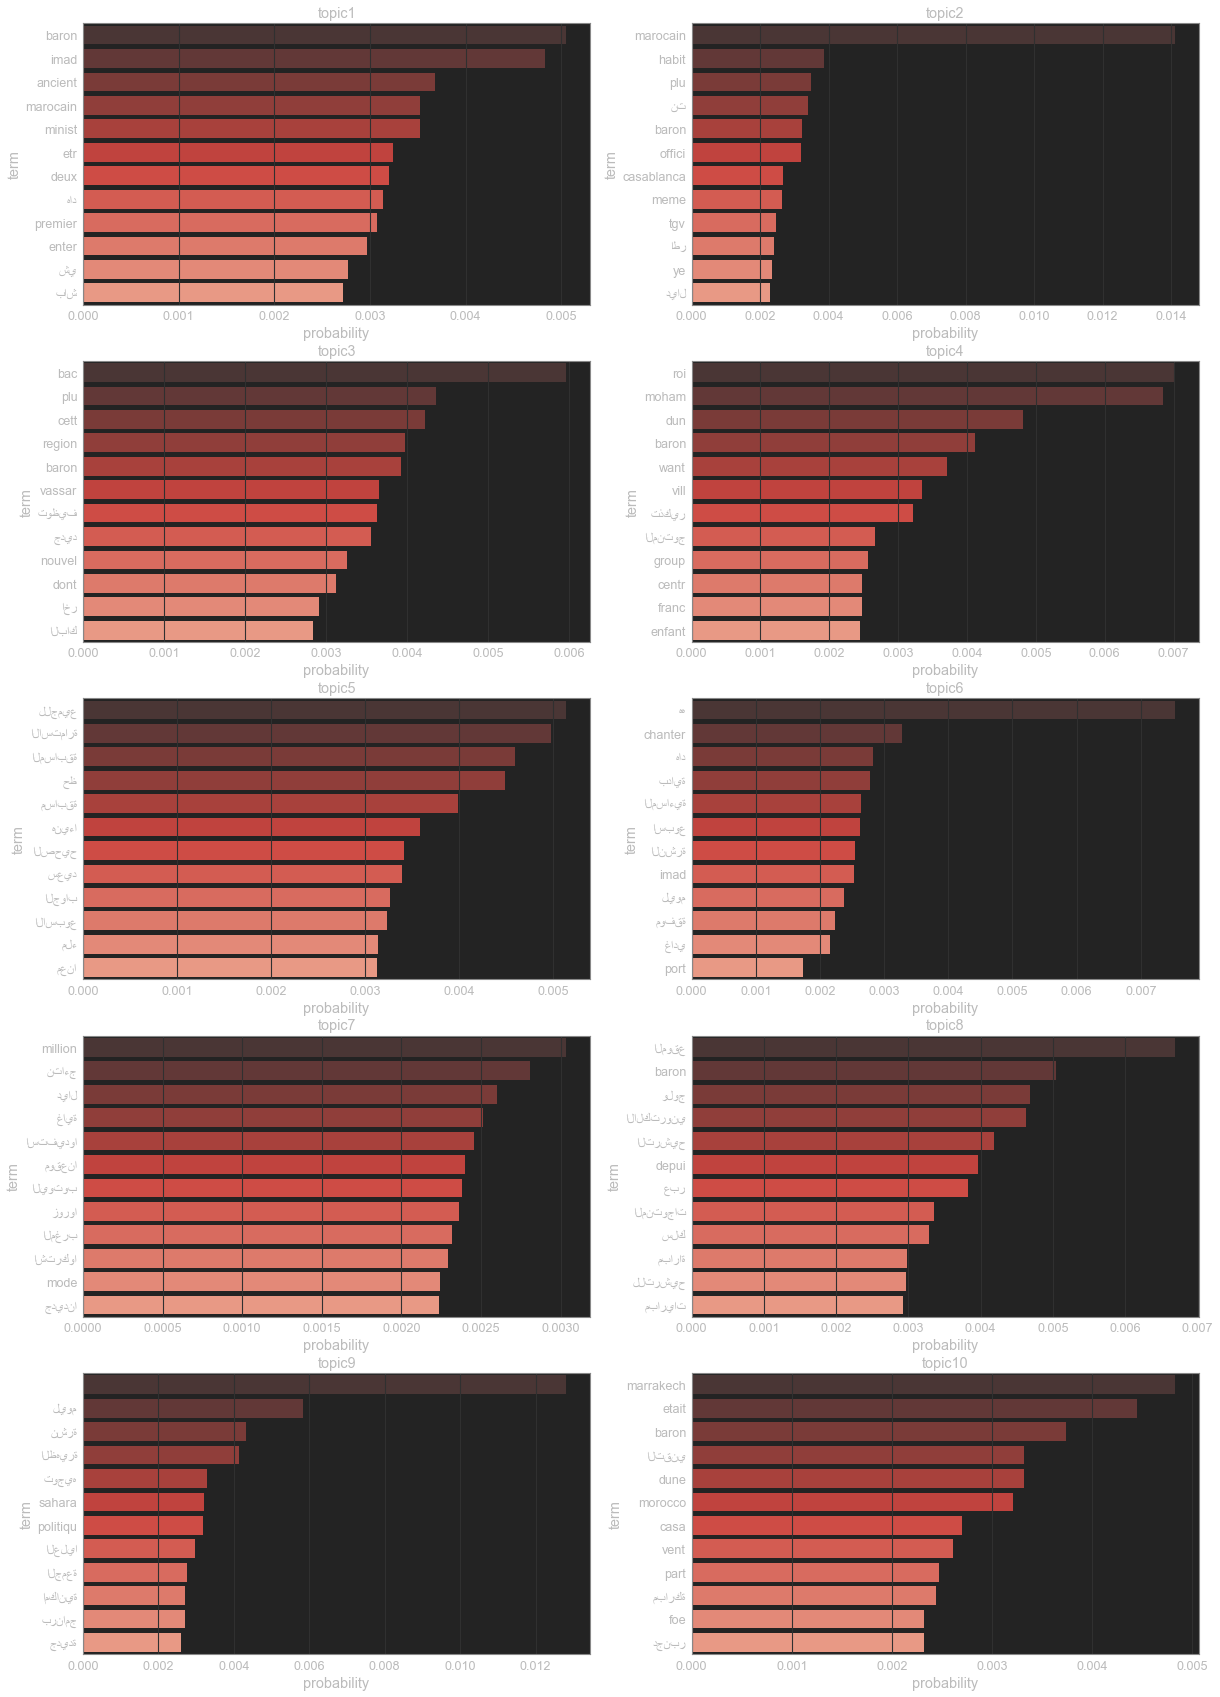

In [64]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import seaborn as sns

fig = plt.figure(figsize = (20,30))
    
for i in range(10):
    df = pd.DataFrame(lda_model_tfidf.show_topic(i,12), columns=['term','prob']).set_index('term')
    plt.subplot(5,2,i+1)
    plt.title('topic'+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df , label = 'Cities', palette='Reds_d')
    plt.xlabel('probability')
plt.show()

Our test document has the highest probability to be part of the topic that our model assigned, which is the accurate classification.

</br>

### Testing model on unseen document

In [66]:
unseen_document = 'Marocain  Morocco'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.6999884247779846	 Topic: 0.016*"ديال" + 0.014*"هاد" + 0.012*"شي" + 0.009*"للجميع" + 0.008*"الاستمارة"
Score: 0.033338289707899094	 Topic: 0.019*"ليوم" + 0.010*"نشرة" + 0.009*"premier" + 0.008*"الظهيرة" + 0.007*"الساعة"
Score: 0.033334821462631226	 Topic: 0.011*"maroc" + 0.008*"المسابقة" + 0.007*"الله" + 0.006*"اليوتوب" + 0.005*"انا"
Score: 0.033334068953990936	 Topic: 0.010*"المغرب" + 0.007*"شاركوا" + 0.006*"العالم" + 0.005*"prochain" + 0.004*"deux"
Score: 0.033334068953990936	 Topic: 0.012*"port" + 0.009*"باش" + 0.009*"هاد" + 0.009*"ديال" + 0.006*"شي"
Score: 0.033334068953990936	 Topic: 0.060*"" + 0.010*"enter" + 0.008*"داك" + 0.008*"الموقع" + 0.006*"group"
Score: 0.033334068953990936	 Topic: 0.028*"baron" + 0.012*"ye" + 0.012*"plu" + 0.008*"vill" + 0.007*"cett"
Score: 0.033334068953990936	 Topic: 0.045*"marocain" + 0.031*"هه" + 0.017*"هاد" + 0.008*"marrakech" + 0.007*"هادي"
Score: 0.033334068953990936	 Topic: 0.008*"المغرب" + 0.006*"باك" + 0.006*"عروض" + 0.005*"ضمان" + 0.005

***

### Links ###

- [E-mail :](mailto:m.elkhou@hotmail.com) m.elkhou@hotmail.com
- [GitHub :](https://github.com/m-elkhou) m-elkhou
- [Linkedin :](https://www.linkedin.com/in/m-elkhou/) m-elkhou